WRC+ Predections

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

import predections

In [38]:
fg = pd.read_csv('./data/full/fg_00_24.csv')
nn_02_preds = pd.read_csv('./predicted_data/wrc_pred/nn_02_23_preds.csv')
nn_15_preds = pd.read_csv('./predicted_data/wrc_pred/nn_15_23_preds.csv')
nn_23_preds = pd.read_csv('./predicted_data/wrc_pred/nn_23_preds.csv')
reg_02_preds = pd.read_csv('./predicted_data/wrc_pred/reg_02_23_preds.csv')
reg_15_preds = pd.read_csv('./predicted_data/wrc_pred/reg_15_23_preds.csv')
reg_23_preds = pd.read_csv('./predicted_data/wrc_pred/reg_23_preds.csv')
zips_25 = pd.read_csv('./data/cleaned/zips_25.csv')

age_curve = pd.read_csv('./predicted_data/age_curves.csv')

basic cleaning

In [39]:
reg_02_preds = reg_02_preds.rename(columns={'Name': 't1'})
reg_15_preds = reg_15_preds.rename(columns={'Name': 't1'})
reg_23_preds = reg_23_preds.rename(columns={'Name': 't1'})

In [40]:
reg_02_preds = reg_02_preds.rename(columns={'0': 'proj_wrc+'})
reg_15_preds = reg_15_preds.rename(columns={'0': 'proj_wrc+'})
reg_23_preds = reg_23_preds.rename(columns={'0': 'proj_wrc+'})

In [41]:
nn_02_preds = nn_02_preds.drop(columns=['Unnamed: 0'])
nn_15_preds = nn_15_preds.drop(columns=['Unnamed: 0'])
nn_23_preds = nn_23_preds.drop(columns=['Unnamed: 0'])
reg_02_preds = reg_02_preds.drop(columns=['Unnamed: 0'])
reg_15_preds = reg_15_preds.drop(columns=['Unnamed: 0'])
reg_23_preds = reg_23_preds.drop(columns=['Unnamed: 0'])

uniform names

In [42]:
def clean_names(df):
    df['t1'] = df['t1'].str.split(',').str[0]
    return df

In [43]:
# apply function
nn_02_preds = clean_names(nn_02_preds)
nn_15_preds = clean_names(nn_15_preds)
nn_23_preds = clean_names(nn_23_preds)

#### AVG of Projections

merge dfs together

In [44]:
# merge all dfs together
merged_preds = nn_02_preds.rename(columns={'proj_wrc+': 'proj_wrc+_N02'})

merged_preds = merged_preds.merge(
    nn_15_preds,
    on='t1',
    how='outer',
    suffixes=('', "_N15")
)

merged_preds = merged_preds.merge(
    nn_23_preds,
    on='t1',
    how='outer',
    suffixes=('', '_N23')
)

merged_preds = merged_preds.merge(
    reg_02_preds,
    on='t1',
    how='outer',
    suffixes=("", "_R02")
)

merged_preds = merged_preds.merge(
    reg_15_preds,
    on='t1',
    how='outer',
    suffixes=('', '_R15')
)

merged_preds = merged_preds.merge(
    reg_23_preds,
    on='t1',
    how='outer',
    suffixes=('', '_R23')
)

# rename to name col
merged_preds = merged_preds.rename(columns={'t1':'Name', 'proj_wrc+': 'proj_wrc+_N15'})


Add Zips Proj

In [45]:
# fix name to fit other format
zips_25['Name'] =  zips_25['Name'].str.lower()
zips_25['Name'] = zips_25['Name'].str.replace(r'[^a-z\s]', '', regex=True)
zips_wrc = zips_25[['Name', 'wRC+']]

In [46]:
merged_preds = merged_preds.merge(zips_wrc, 
                                on='Name',  
                                how='outer',
                                suffixes=('', '_zip'))

In [47]:
merged_preds = merged_preds.dropna()
merged_preds = merged_preds.rename(columns={'wRC+':'ZIPS'})

Add Age

In [48]:
fg = fg.query('Season == 2024')
fg['Name'] =  fg['Name'].str.lower()
fg['Name'] = fg['Name'].str.replace(r'[^a-z\s]', '', regex=True)
fg_age = fg[['Name', 'Age']]
fg_age = fg_age.reset_index()
fg_age = fg_age.drop(columns=['index'])

In [49]:
# Merge with fg_age to add Age column
merged_preds = merged_preds.merge(fg_age, 
                                on='Name',  
                                how='inner').drop_duplicates()
                             

Age Curves Cleaning

In [50]:
age_curve = age_curve.drop(columns=['Unnamed: 0'])
age_curve.loc[0, 'wRC+ % change'] = 1.975003287933701
age_curve.loc[1, 'wRC+ % change'] = 1.75003287933701

#### Projection

model weighting

In [51]:
# Calculate weighted average proj_wrc+ across all models
merged_preds['DIPS'] = (
    merged_preds['proj_wrc+_N23'] * .20 +
    merged_preds['proj_wrc+_N15'] * 0.15 +
    merged_preds['proj_wrc+_N02'] * 0.15 +
    merged_preds['proj_wrc+_R23'] * .20 +
    merged_preds['proj_wrc+_R15'] * 0.15 +
    merged_preds['proj_wrc+_R02'] * 0.15
)

Age Adjustment

In [52]:
# Create a dictionary from age_curve for faster lookup
age_adjustments = dict(zip(age_curve['Age'], age_curve['wRC+ % change']))

# Apply age adjustments to DIPS projections
for idx in merged_preds.index:
    player_age = merged_preds.loc[idx, 'Age']
    if player_age in age_adjustments:
        # Add 1 to the percentage change to get the multiplier
        age_multiplier = 1 + (age_adjustments[player_age] / 100)
        merged_preds.loc[idx, 'DIPS'] = merged_preds.loc[idx, 'DIPS'] * age_multiplier

Adjustment Factor to Return to Mean of 100

In [53]:
# mean 
current_mean = merged_preds['DIPS'].mean()

# bring back to wrc+ center
adjustment_factor = 100 / current_mean
merged_preds['DIPS'] = merged_preds['DIPS'] * adjustment_factor

analysis

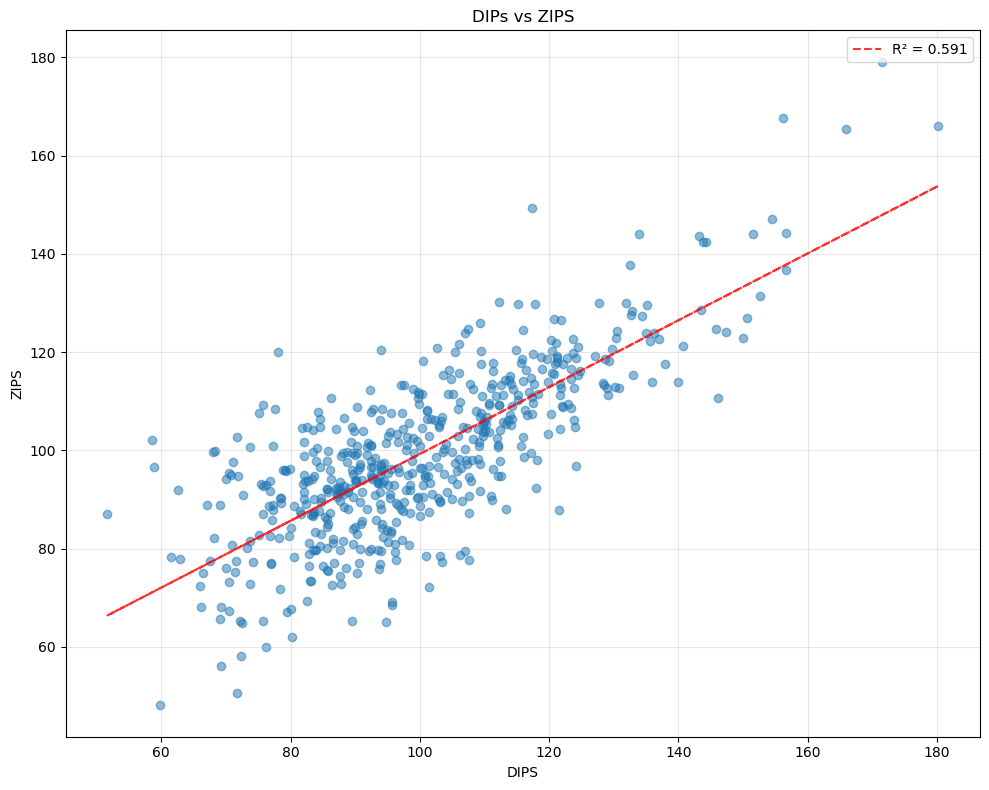

In [54]:
merged_preds['proj_diff'] = merged_preds['DIPS'] - merged_preds['ZIPS']
plt.figure(figsize=(10, 8))
plt.scatter(merged_preds['DIPS'], merged_preds['ZIPS'], alpha=0.5)

# Add line of best fit
z = np.polyfit(merged_preds['DIPS'], merged_preds['ZIPS'], 1)
p = np.poly1d(z)
r2 = np.corrcoef(merged_preds['DIPS'], merged_preds['ZIPS'])[0,1]**2

plt.plot(merged_preds['DIPS'], p(merged_preds['DIPS']), "r--", alpha=0.8, 
         label=f'R² = {r2:.3f}')

plt.xlabel('DIPS')
plt.ylabel('ZIPS')
plt.title('DIPs vs ZIPS')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

export predections

In [55]:
merged_preds = merged_preds.to_excel('./final_preds/wrc_preds_4_28_25.xlsx')